In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

In [59]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [60]:
ls

 bag_output_ukf_polban0807_02.bag  'waypoint_u turn_kanan_1.bag'
 kf_gps.ipynb                      'waypoint_u turn_kanan_2.bag'
 kf_gps.py                         'waypoint_u turn_kanan_3.bag'
 __pycache__/                      'waypoint_u turn_kiri_1.bag'
 speed.png                         'waypoint_u turn_kiri_2.bag'
 test_kf_gps.ipynb


In [127]:
bag = rosbag.Bag('waypoint_u turn_kiri_1.bag')

In [152]:
rpy = []
imu_t = []
for topic, msg, _ in bag.read_messages(topics=['/imu']):
    qt = msg.orientation
    rpy.append(to_euler(qt.x, qt.y, qt.z, qt.w))
    imu_t.append(msg.header.stamp.to_sec())
imu_t = np.array(imu_t)
rpy = np.array(rpy)

In [128]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

# Ambil yang bagus-bagus aja
gnss_pos = np.copy(gps_pos[:-1])
gnss_t = np.copy(gps_t[:-1])
gnss_cov = np.copy(gps_cov[:-1])

In [129]:
gps_pos = (-1) * np.copy(gnss_pos[:,:2])
gps_t = np.copy(gnss_t)

# PAKAI CLASS KF_gps

In [130]:
from kf_gps import KF_gps

In [162]:
f = 100 #Hz
dt = 1/f #s
Tf = int(gps_t[-1] - gps_t[0] + 0.5)
var_gps_pos =  0.5 **2
var_gps_speed = 0.25 **2
var_gps_yaw = 0.1 **2
var_gps_w = 0.01 **2

Q = np.eye(8)
Q[:2,:2] = np.eye(2) * 3.**2
Q[2:4,2:4] = np.eye(2) * 3.**2
Q[4:6,4:6] = np.eye(2) * 0.1**2
Q[6,6] = 1.**2
Q[7,7] = 0.1**2

t = np.array([i*dt for i in range(Tf*f)]) + gps_t[0]

In [163]:
x = np.zeros((f*Tf, 2))
x[0] = gps_pos[0]

v = np.zeros(x.shape)
v[0] = np.array([.0, 0.]) # Tebakan awal
a = np.zeros_like(v) # Tebakan awal

yaw = np.zeros(x.shape[0])
yaw[0] = -0.0
w = np.zeros_like(yaw)
w[0] = 0.05

P = np.zeros((x.shape[0], 8, 8))
P[0, 2:, 2:] = np.eye(6) * 1.

temp_pos_yaw = np.copy(gps_pos[0])

kf = KF_gps(var_gps_pos, var_gps_speed, var_gps_yaw, var_gps_w,
            Q, x[0], v[0], a[0], yaw[0], w[0], P[0])

gps_idx = 1

In [164]:
for i in range(1, x.shape[0]):
    dt = t[i] - t[i-1]

    x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.predict(dt)
    
    if (gps_idx != gps_t.shape[0]) and (gps_t[gps_idx] < t[i]):
        dt_gps = gps_t[gps_idx] - gps_t[gps_idx - 1]
        
        # Correct Position
        x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_position(gps_pos[gps_idx])
        
        # Correct Velocity
        gps_vel = (gps_pos[gps_idx] - gps_pos[gps_idx-1]) / dt_gps
        x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_velocity(gps_vel)
                
        # Correct Yaw dan Omega
        if np.linalg.norm(gps_vel) <= 1e-2: # If the car doesn't move
            x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_w(0.0)
            #print("doesn't move !")
        else:
            dpos = x[i] - temp_pos_yaw
            gps_yaw  = np.arctan2(dpos[1], dpos[0])
            x[i], v[i], a[i], yaw[i], w[i], P[i] = kf.correct_yaw(gps_yaw)
        
        temp_pos_yaw = np.copy(x[i])
        gps_idx += 1

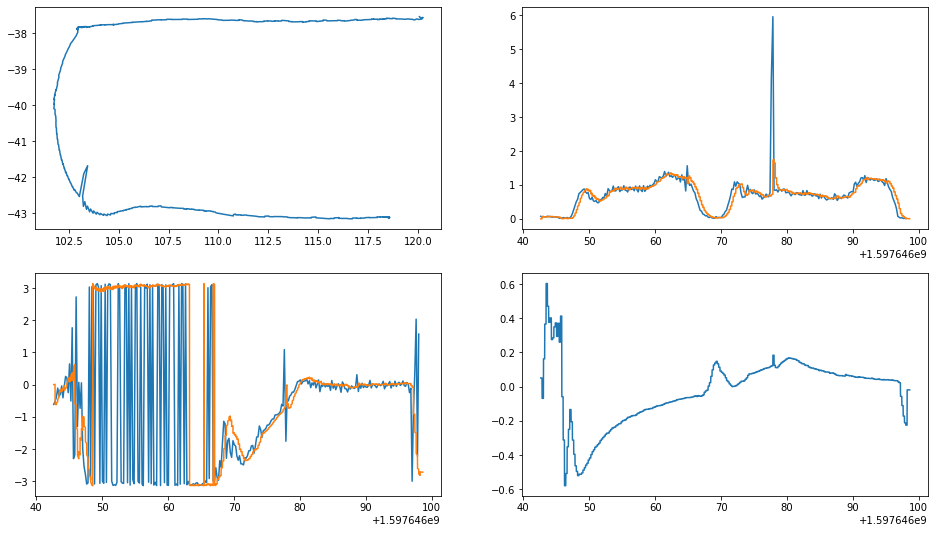

In [165]:
width = 16
height = 9
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(x[:,0], x[:,1])

plt.subplot(2,2,2)

dgps = gps_pos[1:] - gps_pos[:-1]
v_gps = np.zeros((dgps.shape[0],2))
v_gps[:,0] = dgps[:,0] / (gps_t[1:] - gps_t[:-1])
v_gps[:,1] = dgps[:,1] / (gps_t[1:] - gps_t[:-1])
v_gps_norm = np.linalg.norm(v_gps, axis=-1)

plt.plot(gps_t[:-1], v_gps_norm)
plt.plot(t, np.linalg.norm(v,axis=-1))

plt.subplot(2,2,3)
diff = gps_pos[1:] - gps_pos[:-1]
plt.plot(gps_t[:-1], np.arctan2(diff[:,1], diff[:,0]))
plt.plot(t, yaw)

plt.subplot(2,2,4)
plt.plot(t, w)

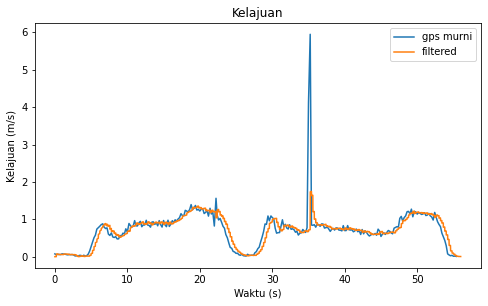

In [166]:
plt.figure(figsize=(8,4.5))

plt.plot(gps_t[:-1] - gps_t[0], v_gps_norm, label='gps murni')
plt.plot(t - t[0], np.linalg.norm(v,axis=-1), label='filtered')
plt.title("Kelajuan")
plt.xlabel("Waktu (s)")
plt.ylabel("Kelajuan (m/s)")
plt.legend()
plt.savefig('speed.png', dpi=500, transparent=True)
plt.show()

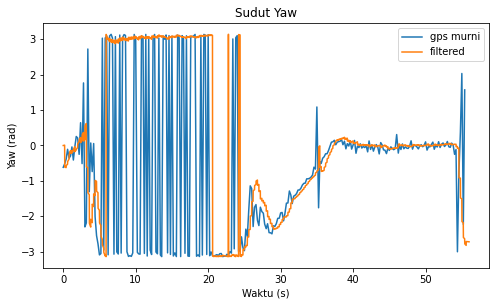

In [167]:
plt.figure(figsize=(8,4.5))

plt.plot(gps_t[:-1] - gps_t[0], np.arctan2(diff[:,1], diff[:,0]), label='gps murni')
plt.plot(t - t[0], yaw, label='filtered')
plt.title("Sudut Yaw")
plt.xlabel("Waktu (s)")
plt.ylabel("Yaw (rad)")
plt.legend()
#plt.savefig('yaw.png', dpi=500, transparent=True)
plt.show()